In [1]:
%matplotlib notebook
import numpy as np
from scipy.stats import kde
from scipy.ndimage.filters import gaussian_filter
import pandas as pd
import os
import shutil
import subprocess
from subprocess import Popen
import datetime
import matplotlib.pyplot as plt  # plotting
import xlrd

from decimal import Decimal

from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm
from scipy.stats import binned_statistic_2d

# make prefix for figure filenames
now = datetime.datetime.now()
date = now.strftime('%Y%m%d')
pref = date

In [5]:
import openpyxl

In [ ]:
# from openpyxl import load_workbook
# wb1 = load_workbook(nog)

In [2]:
nogoplane = '2018June_Tomo26/Reference_Plane.txt'

In [3]:
# working_dir = os.curdir
actinfile1 = '2018June_Tomo26/UnbranchedActin_2018June_Tomo26_CME_Invagination.txt'
actinfile2 = '2018June_Tomo26/BranchedActin_2018June_Tomo26_CME_Invagination.txt'
membranefile = '2018June_Tomo26/Membrane_2018June_Tomo26_CME_Invagination.txt'
#TODO: add in excel file into the code 
#excelfile = 'placeholder.txt'
excelfile = pd.read_excel('2018June_Tomo26/UnbranchedFilamentOrientationInfo.xlsx')
# c = open(membranefile,'r')
# c.readlines()
nogoplane = '2018June_Tomo26/Reference_Plane.txt'

In [39]:
data_xls = excelfile
data_xls

#Purpose: Fix differences between folders
if 'Contour Number In Model' in data_xls.columns:
    data_xls = data_xls.rename(columns = {'Contour Number In Model': 'Contour number in model'})

#Purpose: Read unbranched coords txt file into a dataframe which is returned.
def read_text_unbranched_coords(file, label = 'fil'):
    import pandas as pd
    ub_coordsfile =  open(file, 'r')
    coords = pd.read_table(ub_coordsfile, delim_whitespace=True)
    coords.columns = ['Contour number in model', 'X', 'Y', 'Z']
    return coords
ub_coords = read_text_unbranched_coords(actinfile1)


#Purpose: Merge unbranched coords txt file with dataframe from excel file
def merge_files(unbranched_coords, xls_to_df):
    data_xls = xls_to_df
    merged_ub_coords = data_xls.merge(unbranched_coords)
    merged_ub_coords['X_nm'], merged_ub_coords['Y_nm'], merged_ub_coords['Z_nm'] = 0.06*merged_ub_coords['X'], 0.06*merged_ub_coords['Y'], 0.06*merged_ub_coords['Z']
#   merged_ub_coords = merged_ub_coords[['Contour number in model','X','Y','Z','X_nm','Y_nm','Z_nm','Plus end point','Minus end point','Clear Result (0-1)', \
#               'Filament length (nm)','Comment']]
    return merged_ub_coords
ub_coords
print(ub_coords.columns)
print(data_xls.columns)
merged_df = merge_files(ub_coords, data_xls)
merged_df

#Purpose: Add tag to the merged df
plus_ends = {}
for index, row in merged_df.iterrows():
    if(row['Minus-end'] == 1):
        #print('ya')
        plus_ends[row['Contour number in model']] = 'last'
    else:
        plus_ends[row['Contour number in model']] = 'first'
list_of_ends = []
for index, row in merged_df.iterrows():
    if(plus_ends[row['Contour number in model']] == 'last'):
        list_of_ends += ['first']
    else:
        list_of_ends += ['last']
merged_df['minus end point'] = list_of_ends
merged_df.head(50)
merged_df= merged_df.rename(columns = {'Contour number in model':'contour'})
merged_df

#Purpose: Select certain columns from merged table only
selected = merged_df[['contour', 'X', 'Y', 'Z', 'minus end point']]
selected= selected.rename(columns = {'contour':'fil'})
selected_ub_coords = selected.set_index('fil')
selected_ub_coords

Index(['Contour number in model', 'X', 'Y', 'Z'], dtype='object')
Index(['Contour number in model', 'Plus-end', 'Minus-end',
       'Average difference'],
      dtype='object')


,X,Y,Z,minus end point
fil,,,,
2,984,721,127,first
2,973,744,133,first
2,964,766,140,first
2,956,784,145,first
2,949,799,150,first
...,...,...,...,...
128,1378,338,151,first
130,1469,484,144,first
130,1444,501,148,first


In [4]:
#  read in text file
# for all txt filex

# for a particular txt file


def read_text(file, label='fil'):
    
    import pandas as pd
    coordinatesfile = open(file, 'r')
    
    coords_df = pd.read_table(coordinatesfile, delim_whitespace=True)
#     check if there is an 'object' and 'contour' column (membrane)
    if len(coords_df.columns)==4:
        coords_df.columns=[label, 'X', 'Y', 'Z']
        coords_df=coords_df.set_index([label])
    
    elif len(coords_df.columns)==5:
        coords_df.columns=['object', label, 'X', 'Y', 'Z']
        coords_df=coords_df.set_index(['object', label])
        
    else:
        print("unexpected number of columns!")
#     make multiindex
    coordinatesfile.close()
    return coords_df

actin1 = read_text(actinfile1)
actin2 = read_text(actinfile2)
membrane = read_text(membranefile, 'contour')
# membrane
coords = actin2


[[-116050.3        -116059.01428571 -116067.72857143 -116076.44285714
  -116085.15714286 -116093.87142857 -116102.58571429 -116111.3
  -116120.01428571 -116128.72857143]
 [-115911.01666667 -115919.73095238 -115928.4452381  -115937.15952381
  -115945.87380952 -115954.58809524 -115963.30238095 -115972.01666667
  -115980.73095238 -115989.4452381 ]
 [-115771.73333333 -115780.44761905 -115789.16190476 -115797.87619048
  -115806.59047619 -115815.3047619  -115824.01904762 -115832.73333333
  -115841.44761905 -115850.16190476]
 [-115632.45       -115641.16428571 -115649.87857143 -115658.59285714
  -115667.30714286 -115676.02142857 -115684.73571429 -115693.45
  -115702.16428571 -115710.87857143]
 [-115493.16666667 -115501.88095238 -115510.5952381  -115519.30952381
  -115528.02380952 -115536.73809524 -115545.45238095 -115554.16666667
  -115562.88095238 -115571.5952381 ]
 [-115353.88333333 -115362.59761905 -115371.31190476 -115380.02619048
  -115388.74047619 -115397.4547619  -115406.16904762 -1154

<IPython.core.display.Javascript object>


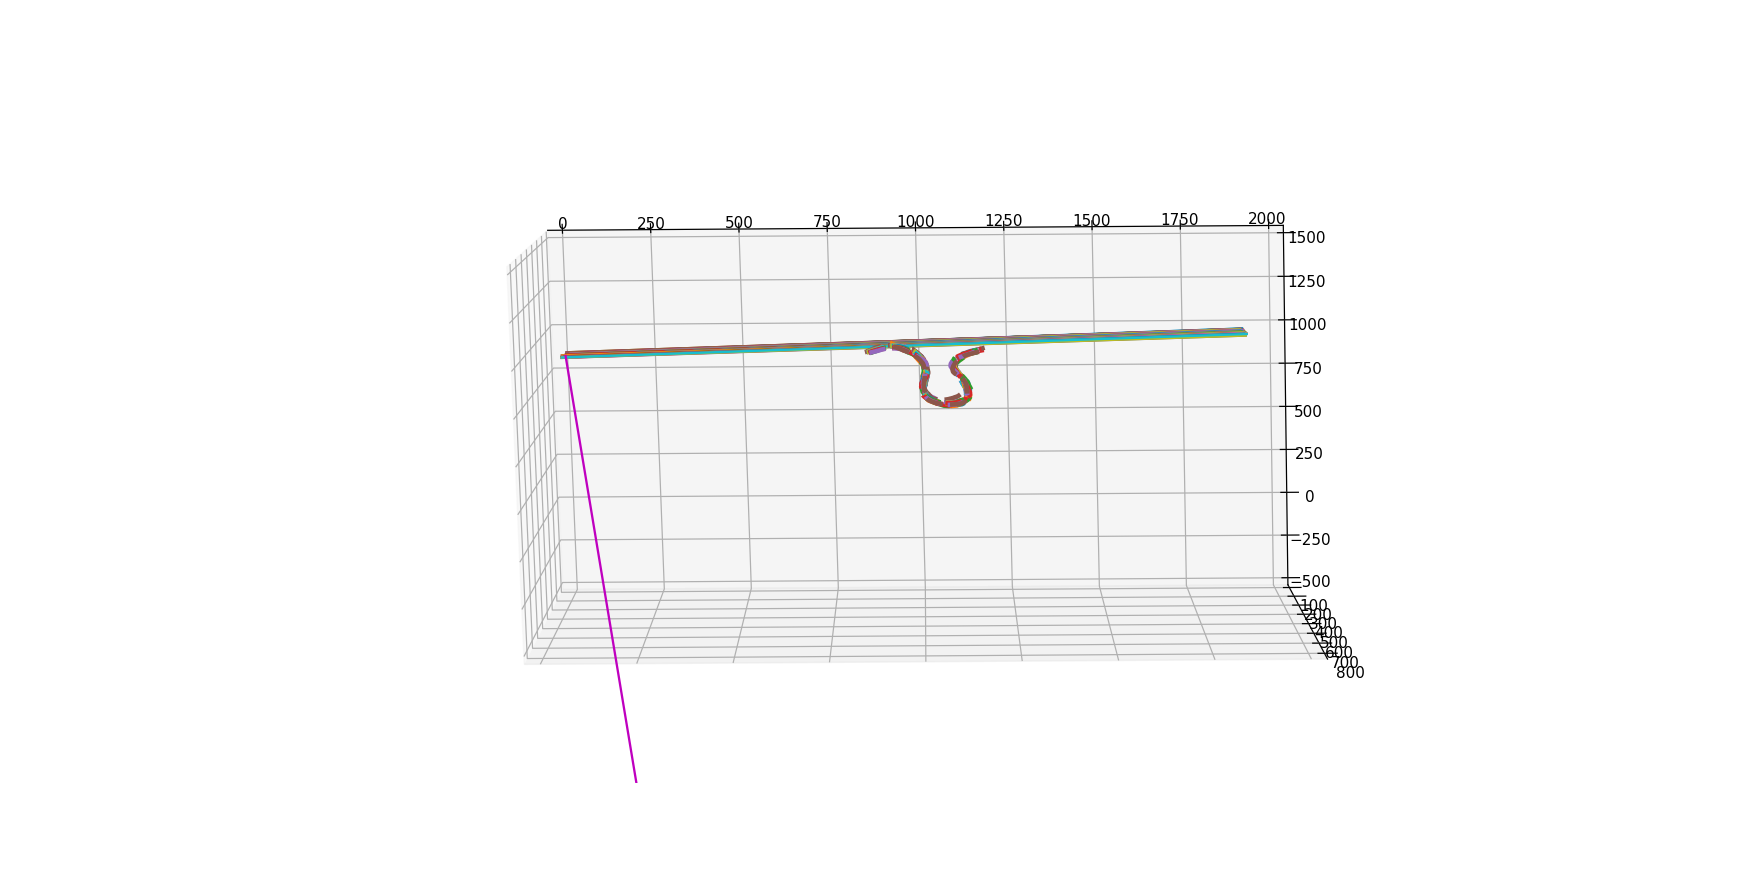

/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/c

In [40]:
#No-Go Plane Definition 
#Taken from here: https://stackoverflow.com/questions/53698635/how-to-define-a-plane-with-3-points-and-plot-it-in-3d
ngplane = read_text(nogoplane)
#ngplane.reset_index()
xvals = ngplane['X'].values
yvals = ngplane['Y'].values
zvals = ngplane['Z'].values
xs = []
ys = []
zs = []


# for i in range(int(xvals.size/2)):
#     a = i+1

# define a plane using any three points from the nogo text file

# e.g. use points 0, 1, and last (-1)

i = 0
j = 1
k =-1

points = [[xvals[i], yvals[i], zvals[i]],
          [xvals[j], yvals[j], zvals[j]], 
          [xvals[k], yvals[k], zvals[k]]]

p0, p1, p2 = points
x0, y0, z0 = p0
x1, y1, z1 = p1
x2, y2, z2 = p2

# calculate vectors between points 0 and 1 (and between 1 and 2)

ux, uy, uz = u = [x1-x0, y1-y0, z1-z0]
vx, vy, vz = v = [x2-x0, y2-y0, z2-z0]

# calcualte cross product

u_cross_v = [uy*vz-uz*vy, uz*vx-ux*vz, ux*vy-uy*vx]

# normal vector as an array

point  = np.array(p0)
normal = np.array(u_cross_v)

d = -point.dot(normal)
xx, yy = np.meshgrid(range(10), range(10))

z = (-normal[0] * xx - normal[1] * yy - d) * 1. / normal[2]
print(z)

# xs.append(xx)
# ys.append(yy)
# zs.append(z)


In [57]:
#More no-go plane stuff
# ngplane = read_text(nogoplane)

# define which mebmrane surface to plot
## object == 1 is the CCP


In [26]:
all_membranes = membrane.reset_index()
CCP = all_membranes[all_membranes['object']==1]


In [27]:
CCP

,object,contour,X,Y,Z
0,1,1,922,897,120
1,1,1,932,885,120
2,1,1,942,880,120
3,1,1,951,870,120
4,1,1,963,862,120
...,...,...,...,...,...
2663,1,16,1162,840,118
2664,1,16,1165,842,118
2665,1,16,1169,843,118
2666,1,16,1172,844,118


In [27]:
# plot membrane

# %matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=[16,8])
ax=fig.add_subplot(111, projection='3d')

for contourr in CCP['contour'].unique():
    cur_contour = CCP[CCP['contour']==contourr]
    ax.plot(xs=cur_contour['X'], ys=cur_contour['Y'], zs=cur_contour['Z'], linewidth=3)

<IPython.core.display.Javascript object>

NameError: name 'CCP' is not defined

<IPython.core.display.Javascript object>


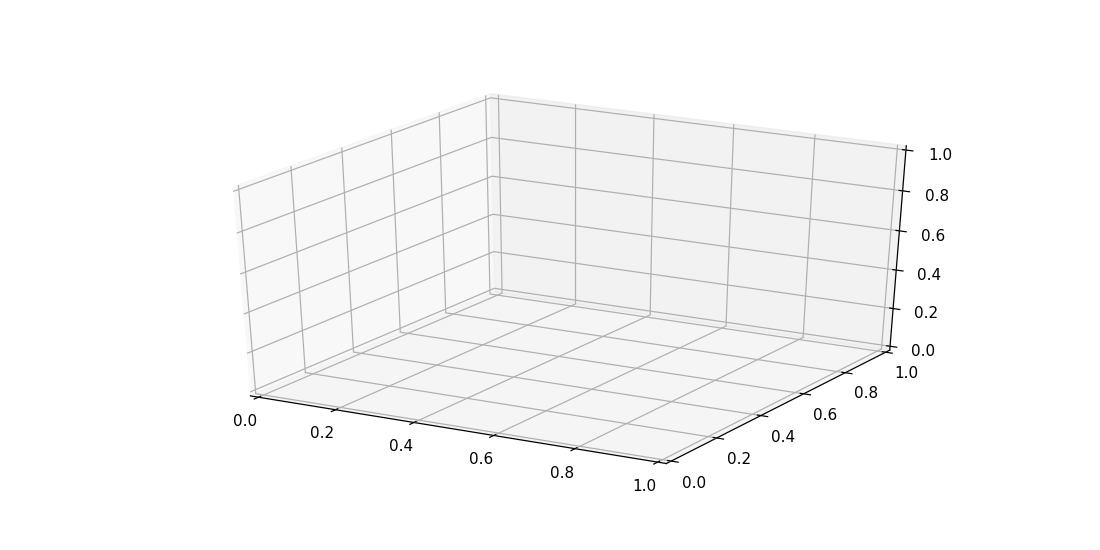

NameError: name 'selected_ub_coords' is not defined

In [24]:
# plot actin and membrane
# %matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=[10,5])
ax=fig.add_subplot(111, projection='3d')

# all_membranes = membrane.reset_index()
# CCP = all_membranes[all_membranes['object']==1]

for filament in selected_ub_coords.index.unique():
    cur_filament = selected_ub_coords[selected_ub_coords.index==filament]
    ax.plot(xs=cur_filament['X'], ys=cur_filament['Y'], zs=cur_filament['Z'], linewidth=3,)

# for filament in coords.index.unique():
#     cur_filament = coords[coords.index==filament]
#     ax.plot(xs=cur_filament['X'], ys=cur_filament['Y'], zs=cur_filament['Z'], linewidth=3)

for contourr in CCP['contour'].unique():
    cur_contour = CCP[CCP['contour']==contourr]
    ax.plot(xs=cur_contour['X'], ys=cur_contour['Y'], zs=cur_contour['Z'], linewidth=3,  linestyle = 'dashed')

for i in range(int(xvals.size/2)):
    ax.plot([xvals[i], xvals[i+1]],[yvals[i], yvals[i+1]], zs = [zvals[i], zvals[i+1]])
 


# plot membrane
# pit = membranes[membranes['contour']==1]
# ax.plot(xs = pit['X'], ys=pit['Y'], zs = pit['Z'], linewidth=5)
# ax.autoscale(enable=True,tight=True) 

plt.xlim([500,1400])
plt.ylim([350,950])
ax.set_zlim([50,250])

ax.set_xticks(np.arange(500,1400,100))
ax.set_yticks(np.arange(400,1000,100))
ax.set_zticks([100,200])


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

In [ ]:
for i in range

In [89]:
#Distance between reference lines & filaments
selected_ub_coords
for index, row in selected_ub_coords.iterrows():
    #line spans p to q and 'r' is the given point
    p = np.array([xvals[0], yvals[0], zvals[0]])
    q = np.array([xvals[1], yvals[1], zvals[1]])
    r = np.array([row.X, row.Y, row.Z])

    def t(p, q, r):
        x = p-q
        return np.dot(r-q, x)/np.dot(x, x)

    def d(p, q, r):
        return np.linalg.norm(t(p, q, r)*(p-q)+q-r)

    print(d(p, q, r))
    

174.86800230393695
152.0387541334286
131.08770028475678
114.45839207528319
101.56667697727319
84.09964335993286
75.73150383835913
70.09850060341608
64.85982693930521
305.96886574973036
272.321492586031
253.29992309286132
226.7259077350533
205.58377746849786
162.102295791279
144.15649907788628
119.62192513554463
101.84871001360817
59.14805124559175
254.52223193694073
223.65198806016912
199.60229711179977
174.73159047987667
159.53067741470667
126.12825597748241
27.92164303613544
41.42991353648485
56.07545660835034
78.80780327314784
100.51175581018805
122.34685880452456
146.99822442632512
159.7459940276911
47.94090338021613
59.679454561607514
72.96245827284417
89.40206660670684
120.65606201247489
138.34638706744173
164.7641125178435
193.49888593468475
215.11962044895432
232.8668892610707
260.7856086868897
83.2013823362879
63.86007709544755
66.67502564982168
79.61281849315897
115.41746649545685
160.67628852465592
187.61870320535675
243.95001139523401
163.4817589917673
124.21015931971965
10

In [ ]:
# plot the nogo lines, membrane contour, and the plane defined by three lines from the nogo file

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=[16,8])
ax = fig.add_subplot(111, projection='3d')

ax.plot(xs=[xvals[0], xvals[1], xvals[-1]],ys =[yvals[0], yvals[1], yvals[-1]], zs = [zvals[0], zvals[1], zvals[-1]],linewidth=2)
for i in range(int(xvals.size/2)):
    ax.plot(xs=[xvals[i], xvals[i+1]],ys =[yvals[i], yvals[i+1]], zs = [zvals[i], zvals[i+1]])

for contourr in CCP['contour'].unique():
    cur_contour = CCP[CCP['contour']==contourr]
    ax.plot(xs=cur_contour['X'], ys=cur_contour['Y'], zs=cur_contour['Z'], linewidth=3,  linestyle = 'dashed')
    
ax.plot(xs = [x0, normal[0]], ys = [y0, normal[1]], zs = [z0, normal[2]], color="m")

plt.xlim([0,2000])
plt.ylim([-500,1500])
ax.zlim([0, 200])

plt.show()

    

# calculate directionality of filaments
## branched filaments here
## ydir is arcsin(y-y0)/length

In [106]:
ydirs=[]
zdirs=[]
all_filaments = []
filament_lengths = []

dot_products = []
relative_angles = []
normal_angles = []

for filament in coords.index.unique():
    cur_filament = coords[coords.index==filament]
    xx = cur_filament.X
    yy = cur_filament.Y
    zz = cur_filament.Z

    deltaxx = sum(np.diff(xx))
    deltayy = sum(np.diff(yy))
    deltazz = sum(np.diff(zz))
    
    fil_vector = (deltaxx, deltayy, deltazz)

#     np.dot(zz.iloc[-1],zz.iloc[0])
    fil_length = np.sqrt(deltaxx*deltaxx+deltayy*deltayy+deltazz+deltazz)

#     calculate the dot product with respect to the normal vector
#     normal_orientation_dp = np.dot(fil_vector, normal)

    # make sure they are unit vectors first
    
    unit_vector_1 = normal_vector / np.linalg.norm(normal_vector)
    unit_vector_2 = fil_vector / np.linalg.norm(fil_vector)
    
#     calculate the dot product bewtween these two vectors.
# NOTE that the sign may have to be manually determined in different datasets. 
# We don't know ahead of time whether the normal vector is pointing "up" or "down."
# so when plotting, we will check whether the value seems to be flipped or not. 
    
    dot_product = -np.dot(unit_vector_1, unit_vector_2)
    
#     relative_angle is the relative angle between the normal vector and the filament vector
    relative_angle = np.degrees(np.arcsin(dot_product))
    
#     we're not usig this value currently
    normal_angle = np.degrees(np.arccos(np.clip(dot_product, -1.0, 1.0)))

    
    dot_products.append(dot_product)
    
    relative_angles.append(relative_angle)
#     normal_angles.append(normal_angle)


# calculate orientation relative to the y axis plane (ydir) or z axis plane (zdir)
#     define direction theta such that 1 is up , 0 is parallel and -1 is down.
# arcsin(z/L)
#   take inverse so that + faces membrane (which is toward zero I think)
#     ydir = (deltayy/fil_length)
    ydir = np.degrees(np.arcsin(deltayy/fil_length))
   
    ydirs.append(ydir)
    
    zdir = np.degrees(-(np.arcsin(deltazz/fil_length)))
#     zdir = -np.arcsin(deltazz/fil_length)

    zdirs.append(zdir)
    
    filament_lengths.append(fil_length)
    
    cur_filament['ydir']=ydir
    cur_filament['zdir']=zdir
    cur_filament['length']=fil_length
    cur_filament['relative_angle'] = relative_angle
    cur_filament['dot_product'] = dot_product
    all_filaments.append(cur_filament)
    
all_filaments_df = pd.concat(all_filaments)
all_filaments_df

/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

,X,Y,Z,ydir,zdir,length,relative_angle,dot_product
fil,,,,,,,,
1,1239,581,224,30.403742,12.804269,302.317714,33.117227,0.546354
1,1220,598,217,30.403742,12.804269,302.317714,33.117227,0.546354
1,1191,624,210,30.403742,12.804269,302.317714,33.117227,0.546354
1,1172,640,205,30.403742,12.804269,302.317714,33.117227,0.546354
1,1138,667,199,30.403742,12.804269,302.317714,33.117227,0.546354
...,...,...,...,...,...,...,...,...
14,1121,458,158,-49.242476,-9.561948,150.499169,-45.050631,-0.707731
14,1092,424,166,-49.242476,-9.561948,150.499169,-45.050631,-0.707731
14,1043,368,178,-49.242476,-9.561948,150.499169,-45.050631,-0.707731


In [21]:
#Directionality of Unbranched Filaments
ydirs=[]
zdirs=[]
all_filaments = []
filament_lengths = []
for filament in selected_ub_coords.index.unique():
    cur_filament = selected_ub_coords[selected_ub_coords.index==filament]
    xx = cur_filament.X
    yy = cur_filament.Y
    zz = cur_filament.Z

    deltaxx = sum(np.diff(xx))
    deltayy = sum(np.diff(yy))
    deltazz = sum(np.diff(zz))

#     np.dot(zz.iloc[-1],zz.iloc[0])
    fil_length = np.sqrt(deltaxx*deltaxx+deltayy*deltayy+deltazz+deltazz)
    
#     calculate the dot product with respect to the normal vector
#     normal_orientation_dp = np.dot(fil_vector, normal)

    # make sure they are unit vectors first
    
    unit_vector_1 = normal_vector / np.linalg.norm(normal_vector)
    unit_vector_2 = fil_vector / np.linalg.norm(fil_vector)
    
#     calculate the dot product bewtween these two vectors.
# NOTE that the sign may have to be manually determined in different datasets. 
# We don't know ahead of time whether the normal vector is pointing "up" or "down."
# so when plotting, we will check whether the value seems to be flipped or not. 
    
    dot_product = -np.dot(unit_vector_1, unit_vector_2)

#  ******   if orientaton of ub filament is plus_end_first, then make dot_product the opposite sign HERE ****



    
#     relative_angle is the relative angle between the normal vector and the filament vector
    relative_angle = np.degrees(np.arcsin(dot_product))
    
#     we're not usig this value currently
    normal_angle = np.degrees(np.arccos(np.clip(dot_product, -1.0, 1.0)))

    
    dot_products.append(dot_product)
    
    relative_angles.append(relative_angle)
#     normal_angles.append(normal_angle)


# calculate orientation relative to the y axis plane (ydir) or z axis plane (zdir)
#     define direction theta such that 1 is up , 0 is parallel and -1 is down.
# arcsin(z/L)
#   take inverse so that + faces membrane (which is toward zero I think)
#     ydir = (deltayy/fil_length)
    ydir = np.degrees(np.arcsin(deltayy/fil_length))
   
    ydirs.append(ydir)
    
    zdir = np.degrees(-(np.arcsin(deltazz/fil_length)))
#     zdir = -np.arcsin(deltazz/fil_length)

    zdirs.append(zdir)
    
    filament_lengths.append(fil_length)
    
    cur_filament['ydir']=ydir
    cur_filament['zdir']=zdir
    cur_filament['length']=fil_length
    cur_filament['relative_angle'] = relative_angle
    cur_filament['dot_product'] = dot_product
    all_filaments.append(cur_filament)
    
ub_all_filaments_df = pd.concat(all_filaments)
ub_all_filaments_df

/Users/kvegesna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/kvegesna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/kvegesna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

,X,Y,Z,minus end point,ydir,zdir,length
fil,,,,,,,
2,984,721,127,first,66.864901,-15.405979,146.805994
2,973,744,133,first,66.864901,-15.405979,146.805994
2,964,766,140,first,66.864901,-15.405979,146.805994
2,956,784,145,first,66.864901,-15.405979,146.805994
2,949,799,150,first,66.864901,-15.405979,146.805994
...,...,...,...,...,...,...,...
128,1378,338,151,first,21.803587,0.967371,177.693556
130,1469,484,144,first,43.933862,-8.253353,83.594258
130,1444,501,148,first,43.933862,-8.253353,83.594258


In [48]:
# plot lengths sanity check
print(np.mean(filament_lengths))
plt.hist(filament_lengths)
# plt.show()

148.00304762792672


(array([2., 5., 3., 0., 0., 1., 1., 0., 0., 1.]),
 array([ 26.30589288,  69.75881474, 113.2117366 , 156.66465847,
        200.11758033, 243.57050219, 287.02342406, 330.47634592,
        373.92926778, 417.38218965, 460.83511151]),
 <a list of 10 Patch objects>)

In [71]:
# hsv 75% colormap
# https://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib
# %matplotlib inline
import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('hsv')
new_cmap = truncate_colormap(cmap, 0, 0.75)

In [102]:
# choose a colormap

import matplotlib.colors as colors
import matplotlib.cm as cmx

colorss = cm = plt.get_cmap('bwr') 
# colorss = cm = plt.get_cmap('viridis') 

# colorss = cm = plt.get_cmap(new_cmap)
 
# cNorm  = colors.Normalize(vmin=0, vmax=values[-1])


# cNorm  = colors.Normalize(vmin=-180, vmax=180)

# set colorlim to [-1 to 1]
cNorm  = colors.Normalize(vmin=-1, vmax=1)

scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=colorss)
print(scalarMap.get_clim())


(-1.0, 1.0)


<IPython.core.display.Javascript object>


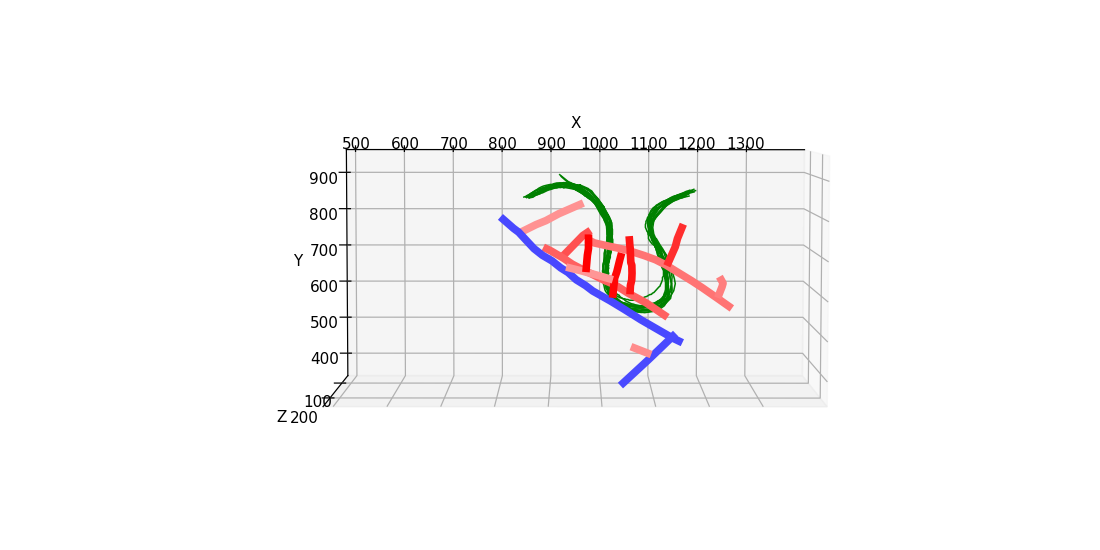

/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/Users/makamats/opt/anaconda3/envs/actincme/lib/python3.7/site-packages/matplotlib/c

Text(0.5, 0, 'Z')

In [109]:
# color code angles
# %matplotlib inline
from matplotlib import cm

# plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=[10,5])
ax=fig.add_subplot(111, projection='3d')


# membrane

for contourr in CCP['contour'].unique():
    cur_contour = CCP[CCP['contour']==contourr]
    ax.plot(xs=cur_contour['X'], ys=cur_contour['Y'], zs=cur_contour['Z'], color='g', linewidth=1)

for filament in all_filaments_df.index.unique():
    cur_filament = all_filaments_df[all_filaments_df.index==filament]
#     colorVal = scalarMap.to_rgba(cur_filament['ydir'])
#     colorVal = scalarMap.to_rgba(cur_filament['relative_angle'])
    colorVal = scalarMap.to_rgba(cur_filament['dot_product'])
    
    ax.plot(xs=cur_filament['X'], ys=cur_filament['Y'], zs=cur_filament['Z'], color=colorVal[0], linewidth=5)
    
# for filament in ub_all_filaments_df.index.unique():
#     cur_filament = ub_all_filaments_df[ub_all_filaments_df.index==filament]
#     colorVal = scalarMap.to_rgba(cur_filament['ydir'])
#     ax.plot(xs=cur_filament['X'], ys=cur_filament['Y'], zs=cur_filament['Z'], color=colorVal[0], linewidth=5)
    
plt.xlim([500,1400])
plt.ylim([350,950])
ax.set_zlim([50,250])

ax.set_xticks(np.arange(500,1400,100))
ax.set_yticks(np.arange(400,1000,100))
ax.set_zticks([100,200])
# cbar = fig.colorbar(colorVal,ax=ax)


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

In [ ]:
# save CCP membrane coordinates
CCP=CCP.reset_index().set_index(['object','contour'])

CCP.to_pickle('CCP_membrane_coordinates.pkl')
CCP

In [27]:
# import 3D meshing of membrane made by "symmetrecized plotting.ipynb"
import pickle as pkl
cur_mesh = pkl.load(open('rotate_obj.pkl','rb'))
cur_mesh

FileNotFoundError: [Errno 2] No such file or directory: 'rotate_obj.pkl'

<IPython.core.display.Javascript object>


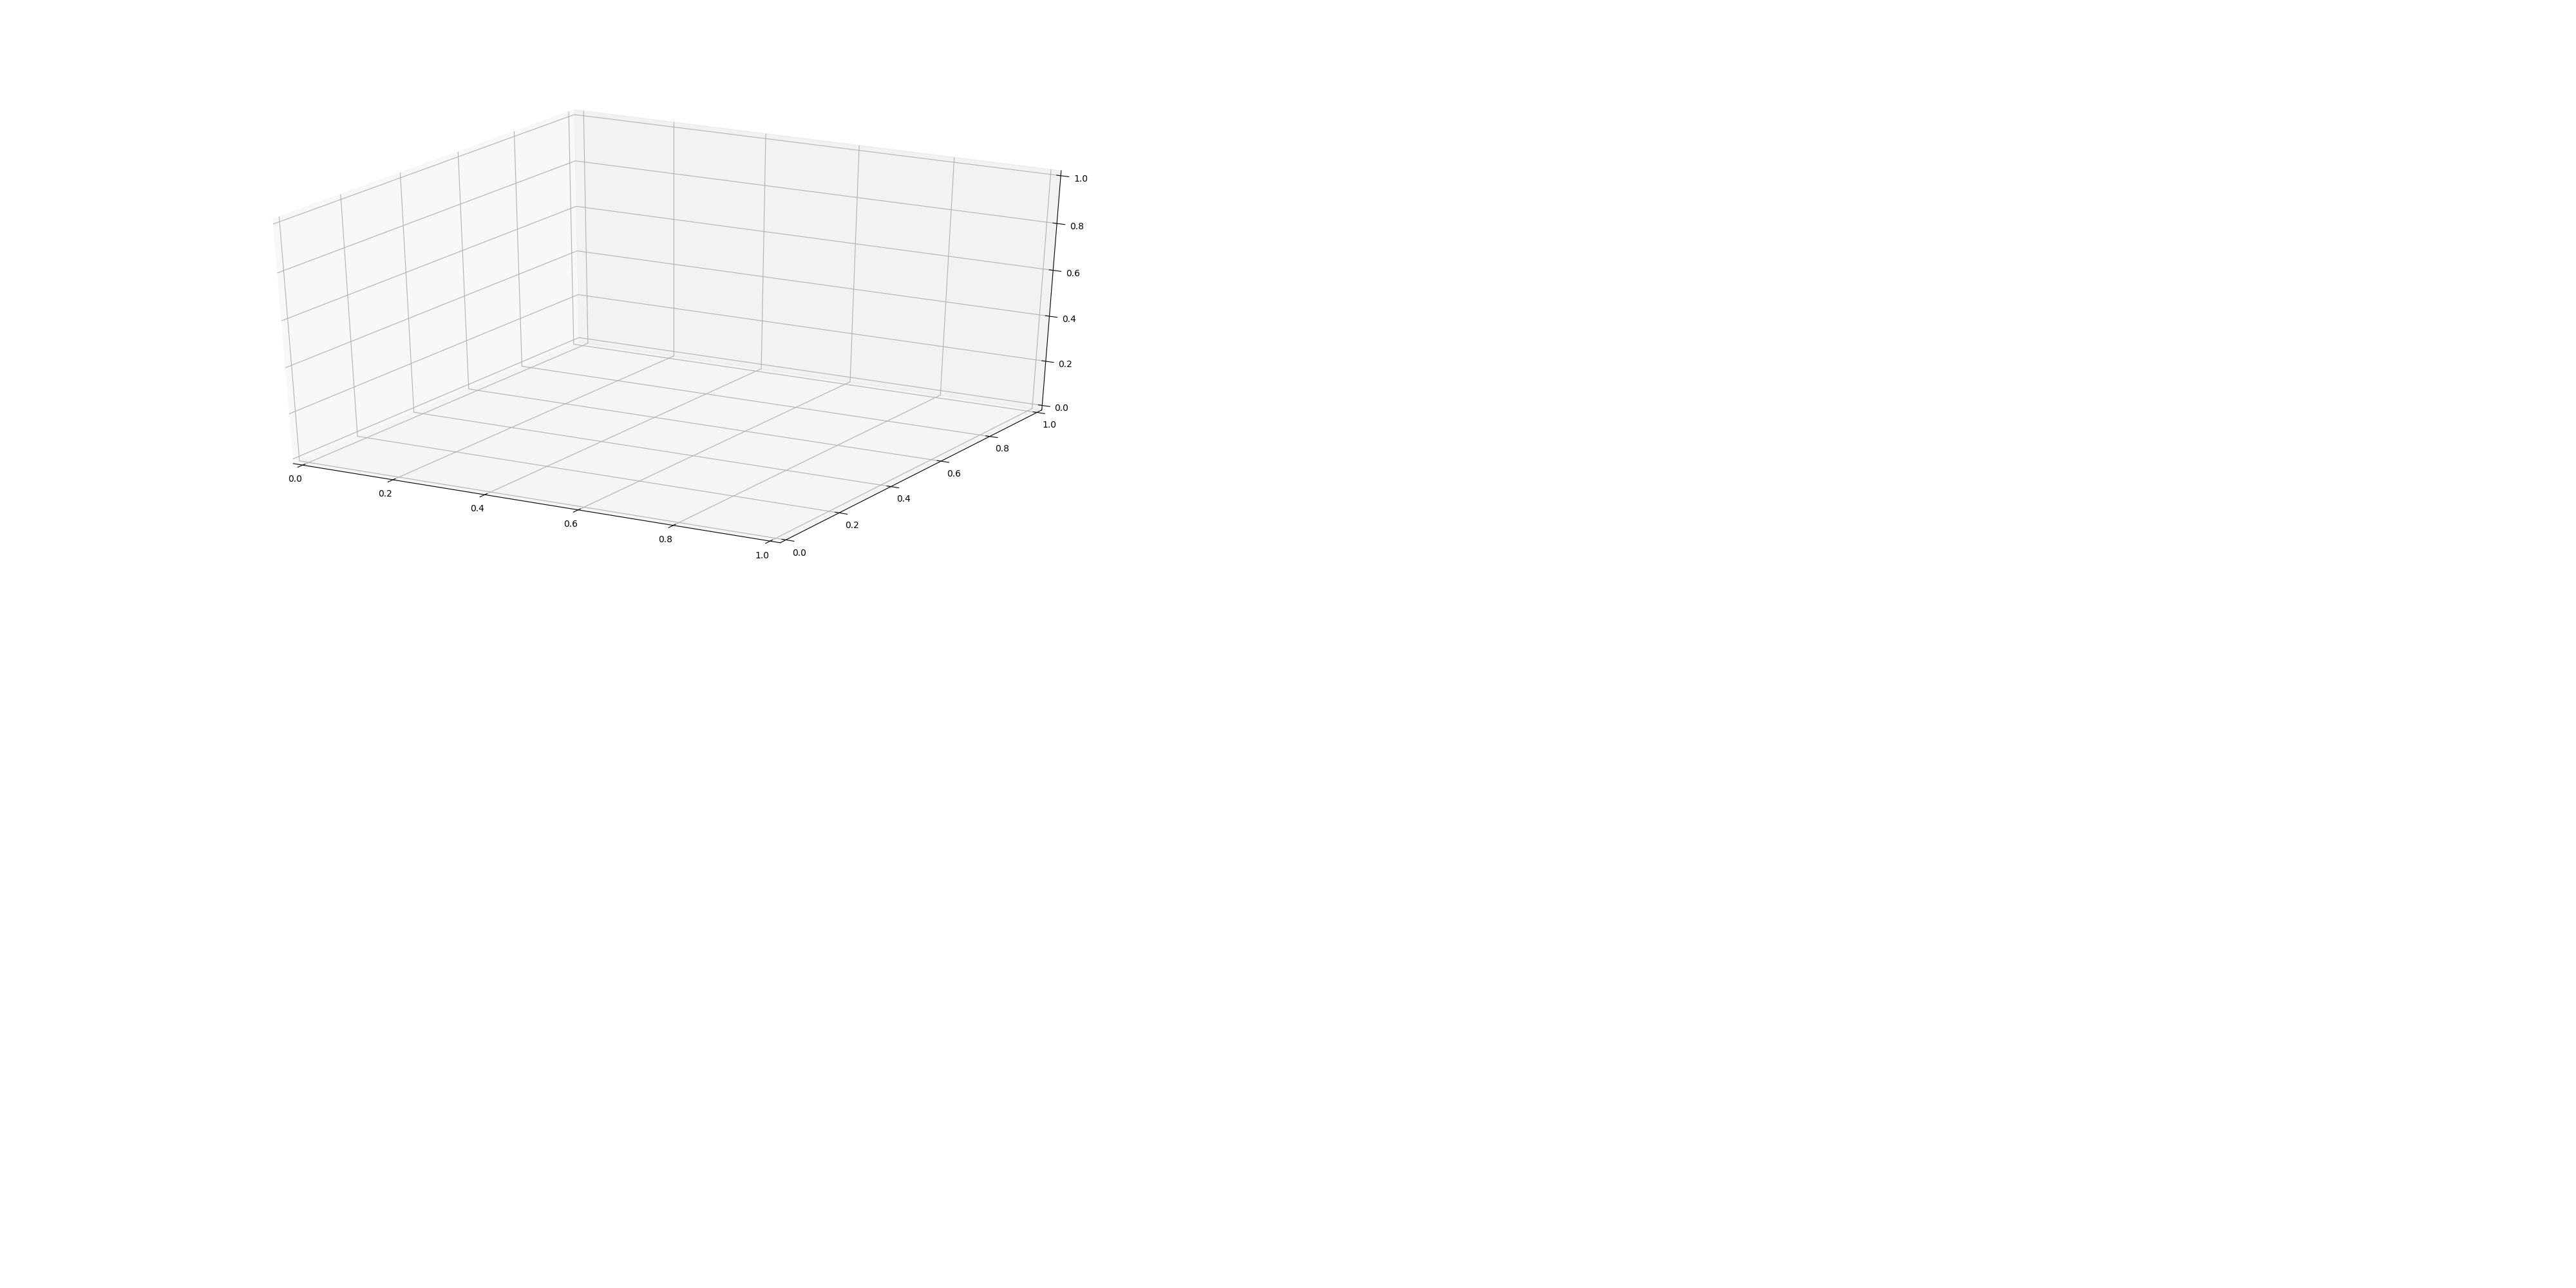

NameError: name 'cur_mesh' is not defined

In [28]:
# plot

fig = plt.figure(figsize=[20,10])
ax=fig.add_subplot(111, projection='3d')

# membrane
ax.plot_surface(cur_mesh.x3d,cur_mesh.y3d, cur_mesh.z3d, color='g', alpha=0.5)

# filaments

for filament in all_filaments_df.index.unique():
    cur_filament = all_filaments_df[all_filaments_df.index==filament]
    colorVal = scalarMap.to_rgba(cur_filament['ydir'])
    ax.plot(xs=cur_filament['X'], ys=cur_filament['Y'], zs=cur_filament['Z'], color=colorVal[0], linewidth=5)
    
# plt.xlim([500,1400])
# plt.ylim([350,950])
# ax.set_zlim([50,250])

# ax.set_xticks(np.arange(500,1400,100))
# ax.set_yticks(np.arange(400,1000,100))
# ax.set_zticks([100,200])


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')


# with actin

In [ ]:
# # arrowheads??
# # https://stackoverflow.com/questions/22867620/putting-arrowheads-on-vectors-in-matplotlibs-3d-plot
# import numpy as np
# from numpy import *
# from matplotlib import pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib.patches import FancyArrowPatch
# from mpl_toolkits.mplot3d import proj3d

# class Arrow3D(FancyArrowPatch):
#     def __init__(self, xs, ys, zs, *args, **kwargs):
#         FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
#         self._verts3d = xs, ys, zs

#     def draw(self, renderer):
#         xs3d, ys3d, zs3d = self._verts3d
#         xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
#         self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
#         FancyArrowPatch.draw(self, renderer)


In [29]:
# fig = plt.figure(figsize=(15,15))
# ax = fig.add_subplot(111, projection='3d')

# a = Arrow3D(xs=cur_filament['X'], ys=cur_filament['Y'], zs=cur_filament['Z'], mutation_scale=20, 
#                 lw=3, arrowstyle="-|>", color="r")
# ax.add_artist(a)


## color code each segment